In [63]:
import os
from openai import AzureOpenAI
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, MessagesState, START, END
import re
from IPython.display import Image


# --- 1. Configuración del Cliente de Azure OpenAI ---


In [64]:
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)
deployment_name = "gpt-4o"

# --- 2. Definición del Estado del Subgrafo ---
# Este diccionario define la "memoria" que se comparte entre los nodos del subgrafo.

In [ ]:
class SubGraphState(TypedDict):
    user_query: str
    sql_query: str
    language: str
    query_results: str
    nl_output: str
    html: str

# --- 2. Datos de Entrada Fijos ---

In [ ]:
fixed_sql_query = """
SELECT
    dc.customer_key,
    dc.first_name || ' ' || dc.last_name AS cliente,
    COUNT(DISTINCT fis.sales_order_number) AS pedidos_totales,
    COUNT(DISTINCT CASE WHEN dpromo.promotion_key IS NOT NULL THEN fis.sales_order_number END) AS pedidos_con_promo,
    ROUND(
        100.0 * COUNT(DISTINCT CASE WHEN dpromo.promotion_key IS NOT NULL THEN fis.sales_order_number END) 
        / NULLIF(COUNT(DISTINCT fis.sales_order_number), 0),
        2
    ) AS tasa_conversion_promocion_pct
FROM adventure_works.fact_internet_sales fis
JOIN adventure_works.dim_customer dc
    ON fis.customer_key = dc.customer_key
LEFT JOIN adventure_works.dim_promotion dpromo
    ON fis.promotion_key = dpromo.promotion_key
WHERE fis.order_date BETWEEN '2004-01-01' AND '2020-12-31'
GROUP BY dc.customer_key, cliente
HAVING COUNT(DISTINCT fis.sales_order_number) >= 5
ORDER BY tasa_conversion_promocion_pct DESC
LIMIT 20;
"""

fixed_query_results = """customer_key	cliente	pedidos_totales	pedidos_con_promo	tasa_conversion_promocion_pct
11078	Gina Martin	17	17	100.00
11091	Dalton Perez	28	28	100.00
11131	Amanda Rivera	5	5	100.00
11142	Eduardo Patterson	17	17	100.00
11176	Mason Roberts	28	28	100.00
11185	Ashley Henderson	27	27	100.00
11200	Jason Griffin	27	27	100.00
11203	Luis Diaz	17	17	100.00
11211	Samantha Russell	17	17	100.00
11212	Chloe Campbell	17	17	100.00
11215	Ana Perry	17	17	100.00
11223	Hailey Patterson	27	27	100.00
11241	Lisa Cai	7	7	100.00
11242	Larry Munoz	7	7	100.00
11253	José Hernandez	16	16	100.00
11262	Jennifer Simmons	27	27	100.00
11276	Nancy Chapman	27	27	100.00
11277	Charles Jackson	27	27	100.00
11287	Henry Garcia	27	27	100.00
11019	Luke Lal	17	17	100.00
"""


# --- 4. Definición de los nodos Subgrafo ---

In [ ]:
def analizar_resultados_node(state: SubGraphState) -> dict:
    """
    Nodo que analiza los resultados de la consulta SQL y genera conclusiones y HTML.
    Utiliza el prompt y la lógica exactos del notebook original.
    """
    
    print(">> Entrando en el nodo: analizar_resultados_node")
    sql_query = state['sql_query']
    resultados_tabla = state['query_results']
    
    # El prompt es una copia exacta del proporcionado en el notebook.
    prompt = f"""
    Eres un analista experto en el dominio de la base de datos consultada.

    La consulta realizada es:

    {sql_query}

    Recibirás la salida en texto plano de una consulta SQL:
    
    {resultados_tabla}

    
    Tu tarea es extraer las conclusiones principales de los datos, redactadas de forma breve y directa, sin explicaciones 
    innecesarias ni contexto adicional.
    Dirígete a un usuario con conocimientos en el tema, por lo que no es necesario definir conceptos básicos.
    Máximo 6 frases concisas, usando terminología técnica del dominio cuando corresponda.
    No incluyas datos sin relevancia ni interpretaciones especulativas.
    """

    response = client.chat.completions.create(
        model=deployment_name,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1
    )
    
    analisis_completo = response.choices[0].message.content.strip()
    print("   - Análisis generado.")
    return {"nl_output": analisis_completo}

In [ ]:
def generar_html_node(state: SubGraphState) -> dict:
    """
    Nodo que analiza los resultados de la consulta SQL y genera conclusiones y HTML.
    Utiliza el prompt y la lógica exactos del notebook original.
    """
    print(">> Entrando en el nodo: analizar_resultados_node")
    sql_query = state['sql_query']
    resultados_tabla = state['query_results']
    
    # El prompt es una copia exacta del proporcionado en el notebook.
    prompt = f"""
    Eres un analista experto en el dominio de la base de datos consultada.

    La consulta realizada es:

    {sql_query}

    Recibirás la salida en texto plano de una consulta SQL:
    
    {resultados_tabla}

    
    Tu tarea es a partir de los datos, generar hasta 3 graficos en formato HTML los cuales muestren la informacion mas importante sobre la consulta realizada.
    El archivo HTML debe ser responsive y contener todos los gráficos.
    No incluyas datos sin relevancia ni interpretaciones especulativas.
    """

    response = client.chat.completions.create(
        model=deployment_name,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1
    )
    
    analisis_completo = response.choices[0].message.content.strip()
    print("   - HTML generado.")
    return {"html": analisis_completo}

# --- 5. Construcción del Subgrafo ---


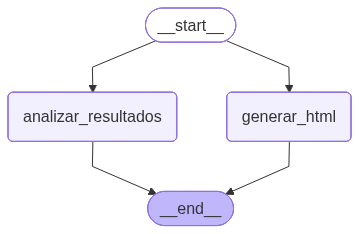

In [69]:
workflow = StateGraph(SubGraphState)

# Añadir el único nodo al grafo
workflow.add_node("analizar_resultados", analizar_resultados_node)
workflow.add_node("generar_html", generar_html_node)

# Definir el flujo: el nodo de análisis es el punto de entrada y de salida.
workflow.add_edge(START, 'analizar_resultados')
workflow.add_edge(START, "generar_html")
workflow.add_edge('analizar_resultados', END)
workflow.add_edge("analizar_resultados", END)

# Compilar el grafo para obtener el subgrafo ejecutable
subgraph_analisis_sql = workflow.compile()

display(Image(subgraph_analisis_sql.get_graph(xray=1).draw_mermaid_png()))



In [ ]:
# --- 6. Invocación del Subgrafo ---
# Un grafo organizador superior le pasaría los datos de la consulta y sus resultados.
print("--- INICIANDO EJECUCIÓN DEL SUBGRAFO ---")
final_state = subgraph_analisis_sql.invoke({
    "sql_query": fixed_sql_query,
    "query_results": fixed_query_results
})
print("--- FINALIZANDO EJECUCIÓN DEL SUBGRAFO ---\n")

# El resultado final está en la clave 'final_analysis' del estado devuelto.
print("--- ANÁLISIS FINAL GENERADO ---")
print(final_state['nl_output'])

--- INICIANDO EJECUCIÓN DEL SUBGRAFO ---
>> Entrando en el nodo: analizar_resultados_node
>> Entrando en el nodo: analizar_resultados_node
   - Análisis generado.
   - HTML generado.
--- FINALIZANDO EJECUCIÓN DEL SUBGRAFO ---

--- ANÁLISIS FINAL GENERADO ---
1. Todos los clientes en la salida tienen una tasa de conversión de promoción del 100%, indicando que la totalidad de sus pedidos incluyeron promociones.  
2. El rango de pedidos totales por cliente varía entre 5 y 28, cumpliendo con el filtro de al menos 5 pedidos.  
3. Los clientes con mayor volumen de pedidos totales (28) son Dalton Perez y Mason Roberts.  
4. La consulta prioriza clientes con alta interacción promocional, ordenando por tasa de conversión y limitando a los 20 principales.  
5. La ventana temporal analizada abarca desde 2004 hasta 2020, con datos exclusivamente de la tabla `fact_internet_sales`.  
6. La relación entre las tablas `dim_customer` y `dim_promotion` permite identificar la incidencia de promociones en 

In [71]:
print(final_state['html'])

Aquí tienes un archivo HTML que contiene tres gráficos relevantes basados en los datos proporcionados. Los gráficos se generan utilizando la biblioteca Chart.js, que es ligera y adecuada para crear gráficos interactivos y responsivos.

### Gráficos incluidos:
1. **Gráfico de barras**: Muestra los pedidos totales por cliente.
2. **Gráfico de barras**: Muestra los pedidos con promoción por cliente.
3. **Gráfico circular (pie chart)**: Muestra la distribución porcentual de los clientes con una tasa de conversión de promoción del 100%.

```html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Resultados de la Consulta SQL</title>
    <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            display: flex;
            flex-direction: column;
            ali

In [72]:
(final_state)

{'sql_query': "\nSELECT\n    dc.customer_key,\n    dc.first_name || ' ' || dc.last_name AS cliente,\n    COUNT(DISTINCT fis.sales_order_number) AS pedidos_totales,\n    COUNT(DISTINCT CASE WHEN dpromo.promotion_key IS NOT NULL THEN fis.sales_order_number END) AS pedidos_con_promo,\n    ROUND(\n        100.0 * COUNT(DISTINCT CASE WHEN dpromo.promotion_key IS NOT NULL THEN fis.sales_order_number END) \n        / NULLIF(COUNT(DISTINCT fis.sales_order_number), 0),\n        2\n    ) AS tasa_conversion_promocion_pct\nFROM adventure_works.fact_internet_sales fis\nJOIN adventure_works.dim_customer dc\n    ON fis.customer_key = dc.customer_key\nLEFT JOIN adventure_works.dim_promotion dpromo\n    ON fis.promotion_key = dpromo.promotion_key\nWHERE fis.order_date BETWEEN '2004-01-01' AND '2020-12-31'\nGROUP BY dc.customer_key, cliente\nHAVING COUNT(DISTINCT fis.sales_order_number) >= 5\nORDER BY tasa_conversion_promocion_pct DESC\nLIMIT 20;\n",
 'sql_results': 'customer_key\tcliente\tpedidos_total